## NOTES:
<ul>
<li>This section is specifically for visualizing the datasets produced by Aquifer Analsys</li>
<li>This section does not generate any new data. Unless otherwise specified, the <strong>input file</strong> for any of these cells is an aquifer analysis spreadsheet of the form <em>Aquifer_Name_Range_Quantile.xlsx</em> </li>
</ul>


## Imports

In [132]:
#Python3.10
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import calendar
from importlib import reload

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func as fn
reload(cl)
reload(fn)

<module 'Src.func' from 'c:\\Users\\alekh\\OneDrive - University of California, Davis\\WORK\\DahlkeLab_LAWR\\Src\\func.py'>

## Single Aquifer Plotting
Plot a single aquifer's water guages based on metric of choice. HUC4 watershed boundaries are the blue zones with the aquifer outline in red.

Controls:

In [3]:
import Src.classes as cl
import Src.func as fn
reload(cl)
reload(fn)

# Dataset selection
aquifer = cl.coastal_lowlands_aquifer
range = 30
quantile = 90

lower48_shp_path = 'ShapeFiles/Lower48/lower48.shp'

try:
    dataset = f'{aquifer.name}_{range}_{quantile}.xlsx'
    datapath = f'Prelim_Data/{aquifer.name}/{dataset}'
    df = pd.read_excel(datapath, sheet_name='site_metrics')
    df_valid, df_invalid = fn.filter_by_valid(df)
    print(f'Valid Sites: {len(df_valid)} of {len(df)}')
    
except Exception as e:
    print(e)

# Metric to be plotted where metrics are column names from the dataset
metric = 'annual_hmf'
# True if you want to overwrite current images
overwrite = False
save_img = False

Valid Sites: 131 of 177


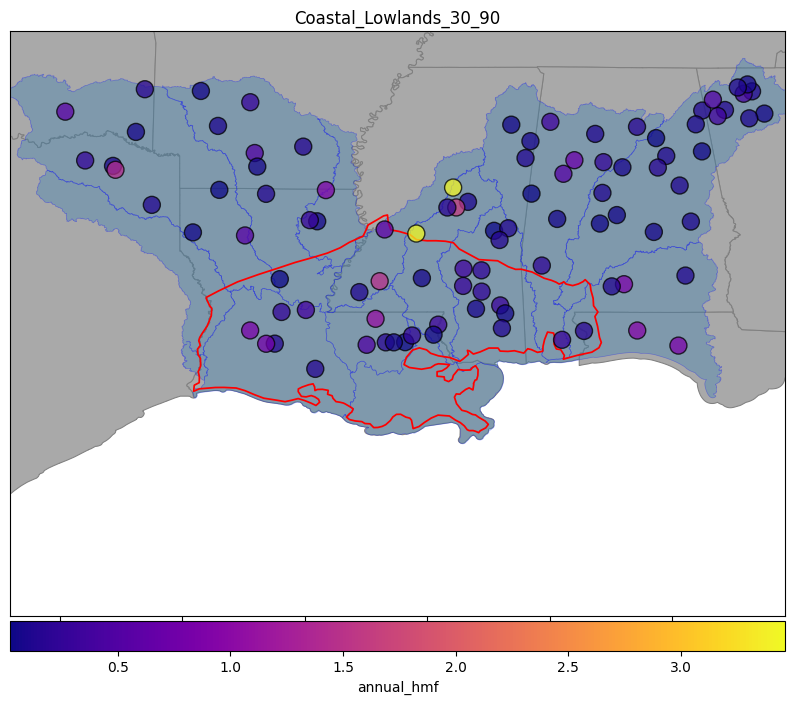

In [4]:
import Src.classes as cl
import Src.func as fn
reload(cl)
reload(fn)

# Set to false when testing watershed/aquifer overlap to speed things up
basemap = False

fig, ax = plt.subplots(figsize=(10, 10))
plt.title(dataset[:-5], loc='center')

# Lower-48 Plot
if not basemap:
    fn.plot_lower_48(ax, lower48_shp_path)

# HUC4 Region Plot
for root, dirs, files in os.walk(aquifer.wb_dir):
    #print(root, dirs, files)
    if os.path.basename(root).startswith('NHD_H_'):
        if aquifer.wb_shapefiles in files:
            shapefile_aq_path = os.path.join(root, aquifer.wb_shapefiles)
            ws_gdf = gpd.read_file(shapefile_aq_path)
            ws_gdf = ws_gdf.to_crs(4269)
            ws_gdf.plot(ax=ax, edgecolor='blue', alpha=0.30, linewidth=0.5)

# Aquifer boundary plot
aq_gdf = gpd.read_file(aquifer.aq_shapefile)
aq_gdf = aq_gdf.to_crs(4269)

xmin, ymin, xmax, ymax = aq_gdf.total_bounds
padding = 3.0
xmin -= padding
ymin -= padding
xmax += padding
ymax += padding

aq_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.25)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Convert decimal lat/long to geo points
geo_df = fn.convert_geometry(df_valid)

# Set colorbar limits and theme using undivided dataset so that scale is static
cmap, mappable = fn.scale_colorbar(df_valid, metric)

div = make_axes_locatable(ax)
cax = div.append_axes("bottom", size="5%", pad=0.05)

# Watergauges plot
bx = geo_df.plot(ax=ax, column=df_valid[metric], markersize=600, marker='.', cmap=cmap, edgecolor='black', linewidth=1, alpha=0.75)
cbx = plt.colorbar(mappable, cax=cax, pad=0.05, aspect=25, orientation='horizontal', alpha=1.0)
cbx.set_label(f'{metric}')
ax.set_yticks([])

# Add context basemap
if basemap:
    fn.plot_basemap(ax)

# Save images if they don't exist or if overwrite is True
if save_img:
    img_path = f'Saved_Visuals/{dataset[:-5]}_{metric}.png'
    fn.save_plot_as_image(img_path, overwrite)

## Multiple Aquifer Plotting
Plot multiple aquifers using multiple datasets on a single map by pointing to a directory with aquifer datasets of matching range and quantile.

Controls:

In [153]:
# List of aquifers to plot
aquifers = [cl.upper_clairborne_aquifer, cl.central_valley_aquifer, cl.columbia_plateau_aquifer, cl.high_plains_aquifer,
            cl.arizona_alluvial_aquifer, cl.snake_river_aquifer, cl.coastal_lowlands_aquifer]
range = 30
quantile = 90

# Metric to be plotted where metrics are column names from the dataset
metric = 'inter_annual'
# True if you want to show HUC4 boundaries (significantly increases runtime)
show_huc4 = True
show_usgs_aqs = True
# True if you want to save image. Overwrite true if you want to overwrite existing image of same name
save_img = False
overwrite = False
# True if you want a context basemap (adds runtime)
basemap = False

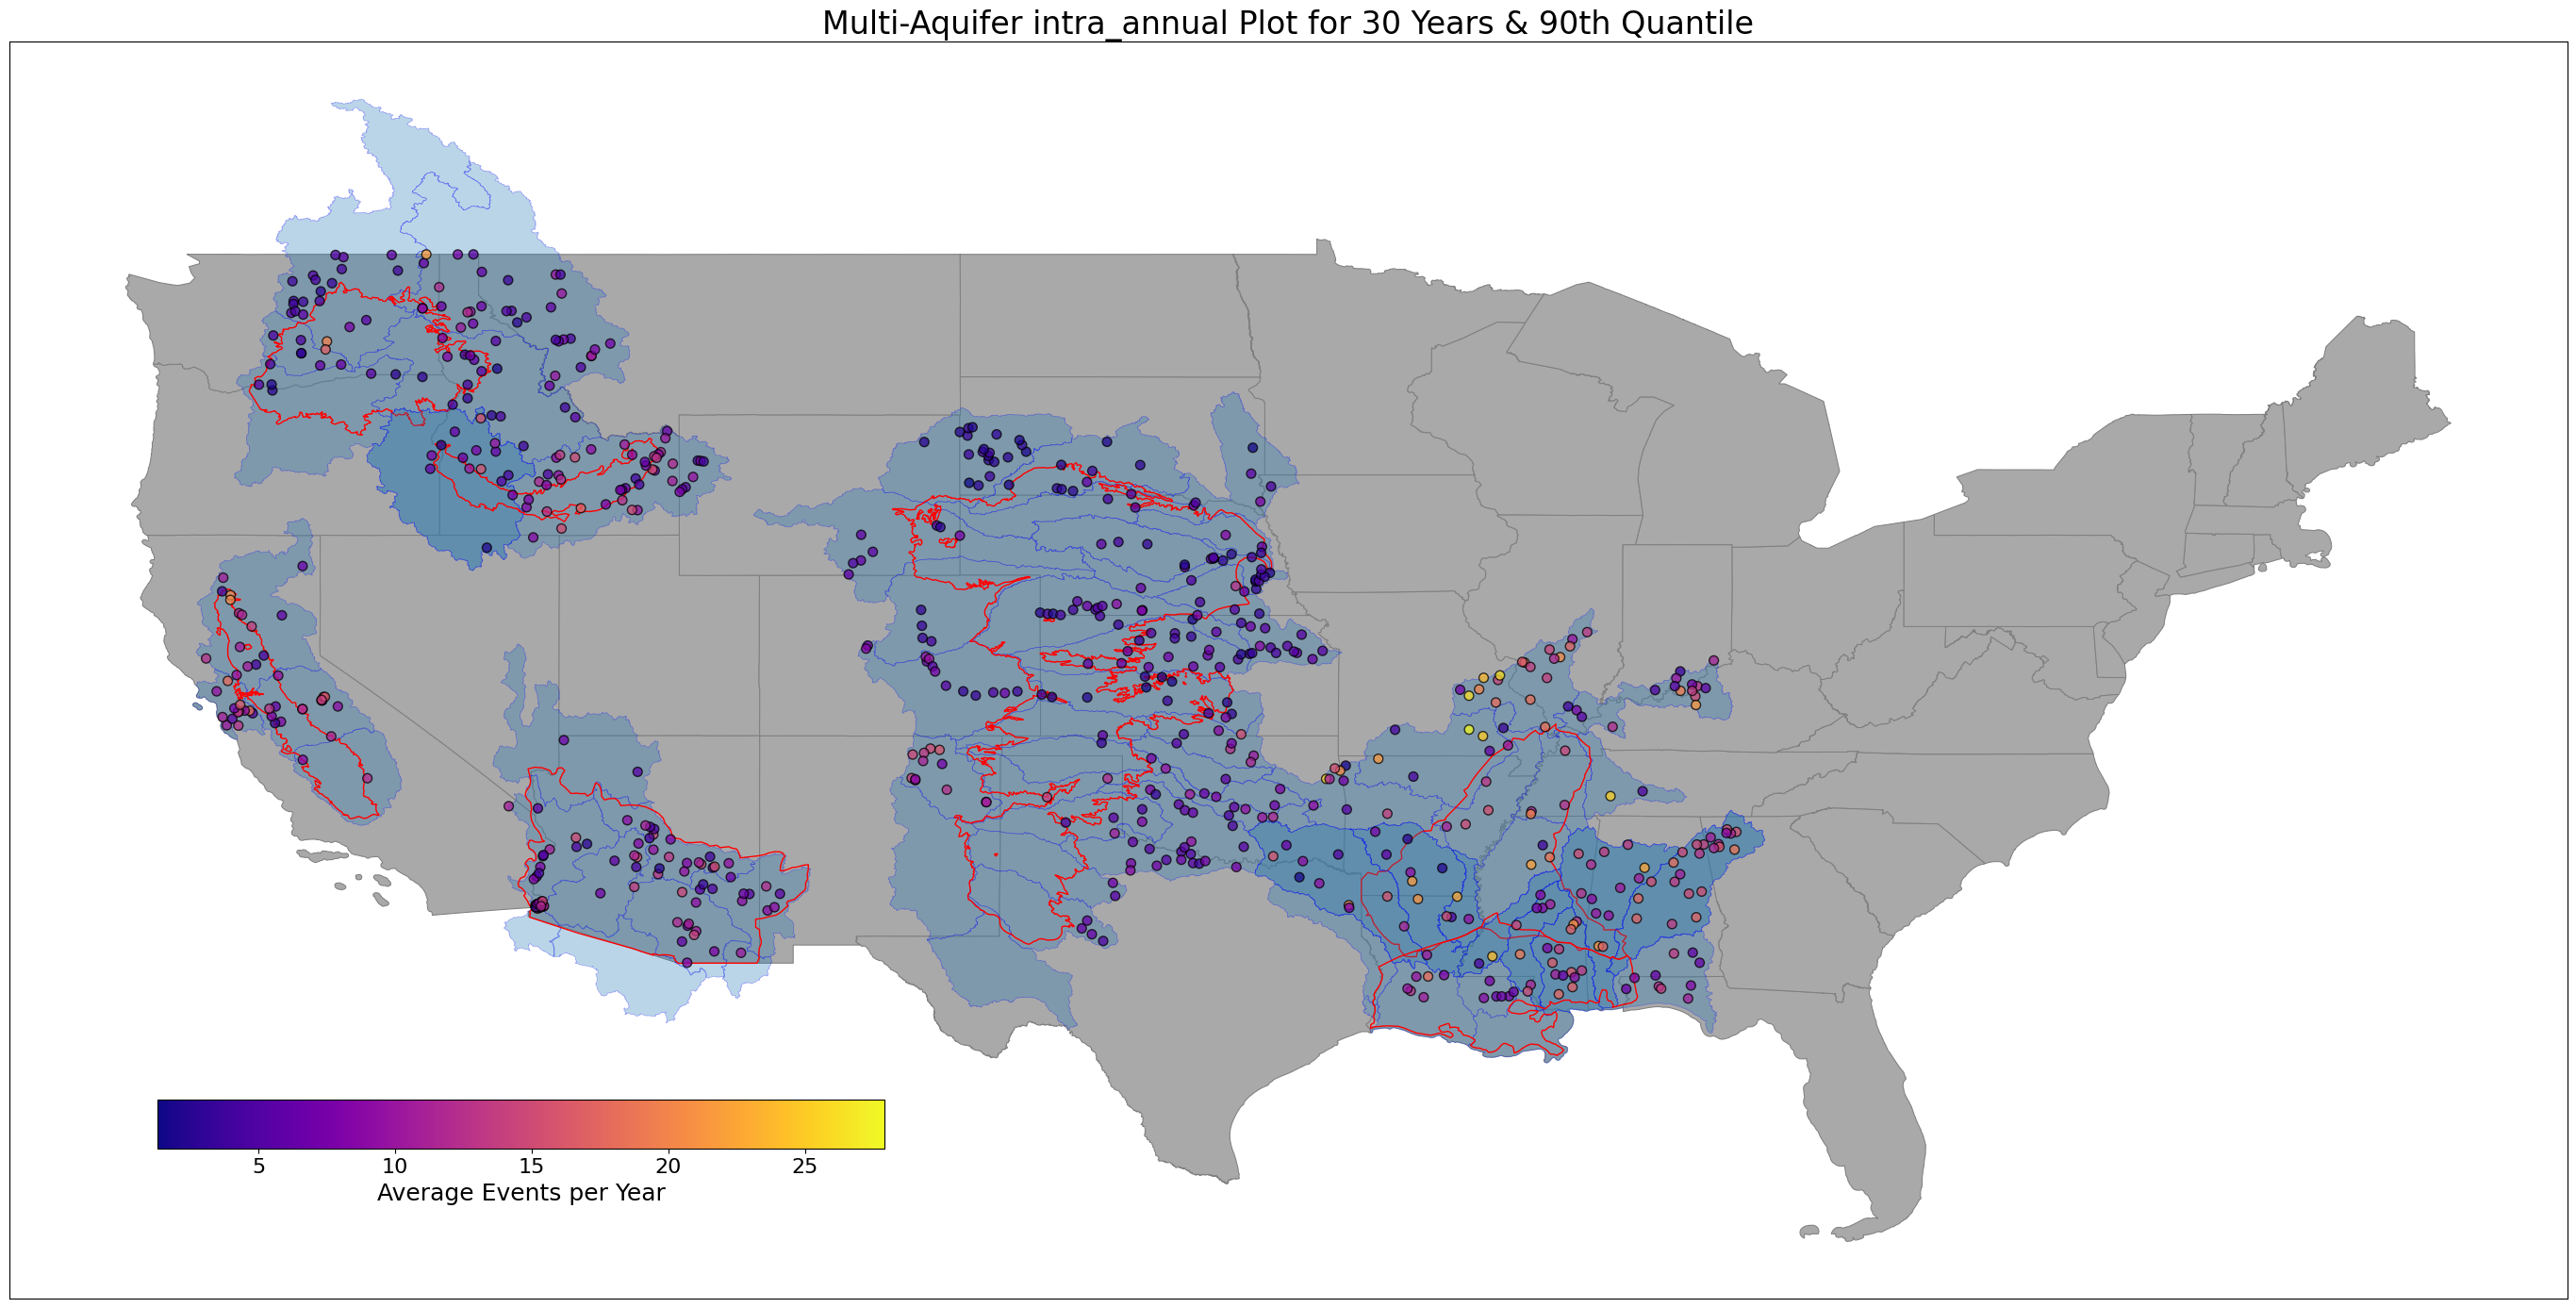

In [154]:
fig, ax = plt.subplots(figsize=(35, 35))
plt.title(f"Multi-Aquifer {metric} Plot for {range} Years & {quantile}th Quantile", loc='center', fontsize=24)

# Lower-48 Plot
if not basemap:
    fn.plot_lower_48(ax)

# Merge all dataframes so we can accurately track min/max values for colorbar scaling
# Additonally, plot HUC4 and aquifer boundaries
df_all_aq = pd.DataFrame()
for aq in aquifers:
    try:
        df = pd.read_excel(f'{aq.datasets_dir}/{aq.name}_{range}_{quantile}.xlsx', sheet_name='site_metrics')
        df_all_aq = pd.concat([df_all_aq, df]).reset_index(drop=True)
    except Exception as e:
        print(f"ERROR: No dataset found for {aq.name} at {aq.datasets_dir}/{aquifer.name}_{range}_{quantile}.xlsx")
        
    # HUC4 Region Plot
    if show_huc4:
        for root, dirs, files in os.walk(aq.wb_dir):
            #print(root, dirs, files)
            if os.path.basename(root).startswith('NHD_H_'):
                if aq.wb_shapefiles in files:
                    shapefile_aq_path = os.path.join(root, aq.wb_shapefiles)
                    ws_gdf = gpd.read_file(shapefile_aq_path)
                    ws_gdf = ws_gdf.to_crs(4269)
                    ws_gdf.plot(ax=ax, edgecolor='blue', alpha=0.30, linewidth=0.5)
                
    # Aquifer Boundary Plot
    if show_usgs_aqs:
        aq_gdf = gpd.read_file(aq.aq_shapefile)
        aq_gdf = aq_gdf.to_crs(4269)
        aq_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.00)
    
# Only plot valid sites, remove duplicates
df_all_aq, _ = fn.filter_by_valid(df_all_aq) 
df_all_aq = df_all_aq.drop_duplicates(subset=['site_no'], keep='first')  

# Convert decimal lat/long to geo points
geo_df = fn.convert_geometry(df_all_aq)

cmap, mappable = fn.scale_colorbar(df_all_aq, metric)

# L/B/W/H
cax = fig.add_axes([0.17, 0.35, 0.22, 0.015]) 
                
# Watergauges plot
bx = geo_df.plot(ax=ax, column=df_all_aq[metric], markersize=200, marker='.', cmap=cmap, edgecolor='black', linewidth=1, alpha=0.75)
cbx = plt.colorbar(mappable, cax=cax, pad=1.0, shrink=0.5, orientation='horizontal', alpha=1.0)
cbx.set_label(fn.FLOW_METRIC_UNITS[metric], size=18)
cbx.ax.tick_params(labelsize=16)  
ax.set_yticks([])
ax.set_xticks([])

if basemap:
    fn.plot_basemap(ax)

# Save images if they don't exist or if overwrite is True
if save_img:
    img_path = f'Saved_Visuals/Multi_Aquifer_{metric}_{range}_{quantile}.png'
    fn.save_plot_as_image(img_path, overwrite)         
    

## National Validity Plot
Plots the validity of every water gauge with daily streamflow data available

In [141]:
dataset = 'National_Validity.xlsx'
datapath = f'Prelim_Data/{dataset}'
lower_48_shp_path = 'ShapeFiles/Lower48/lower48.shp'

show_huc2 = False
show_huc4 = True
show_rateb_aqs = False

df_validity = pd.read_excel(datapath, sheet_name='national_validity')

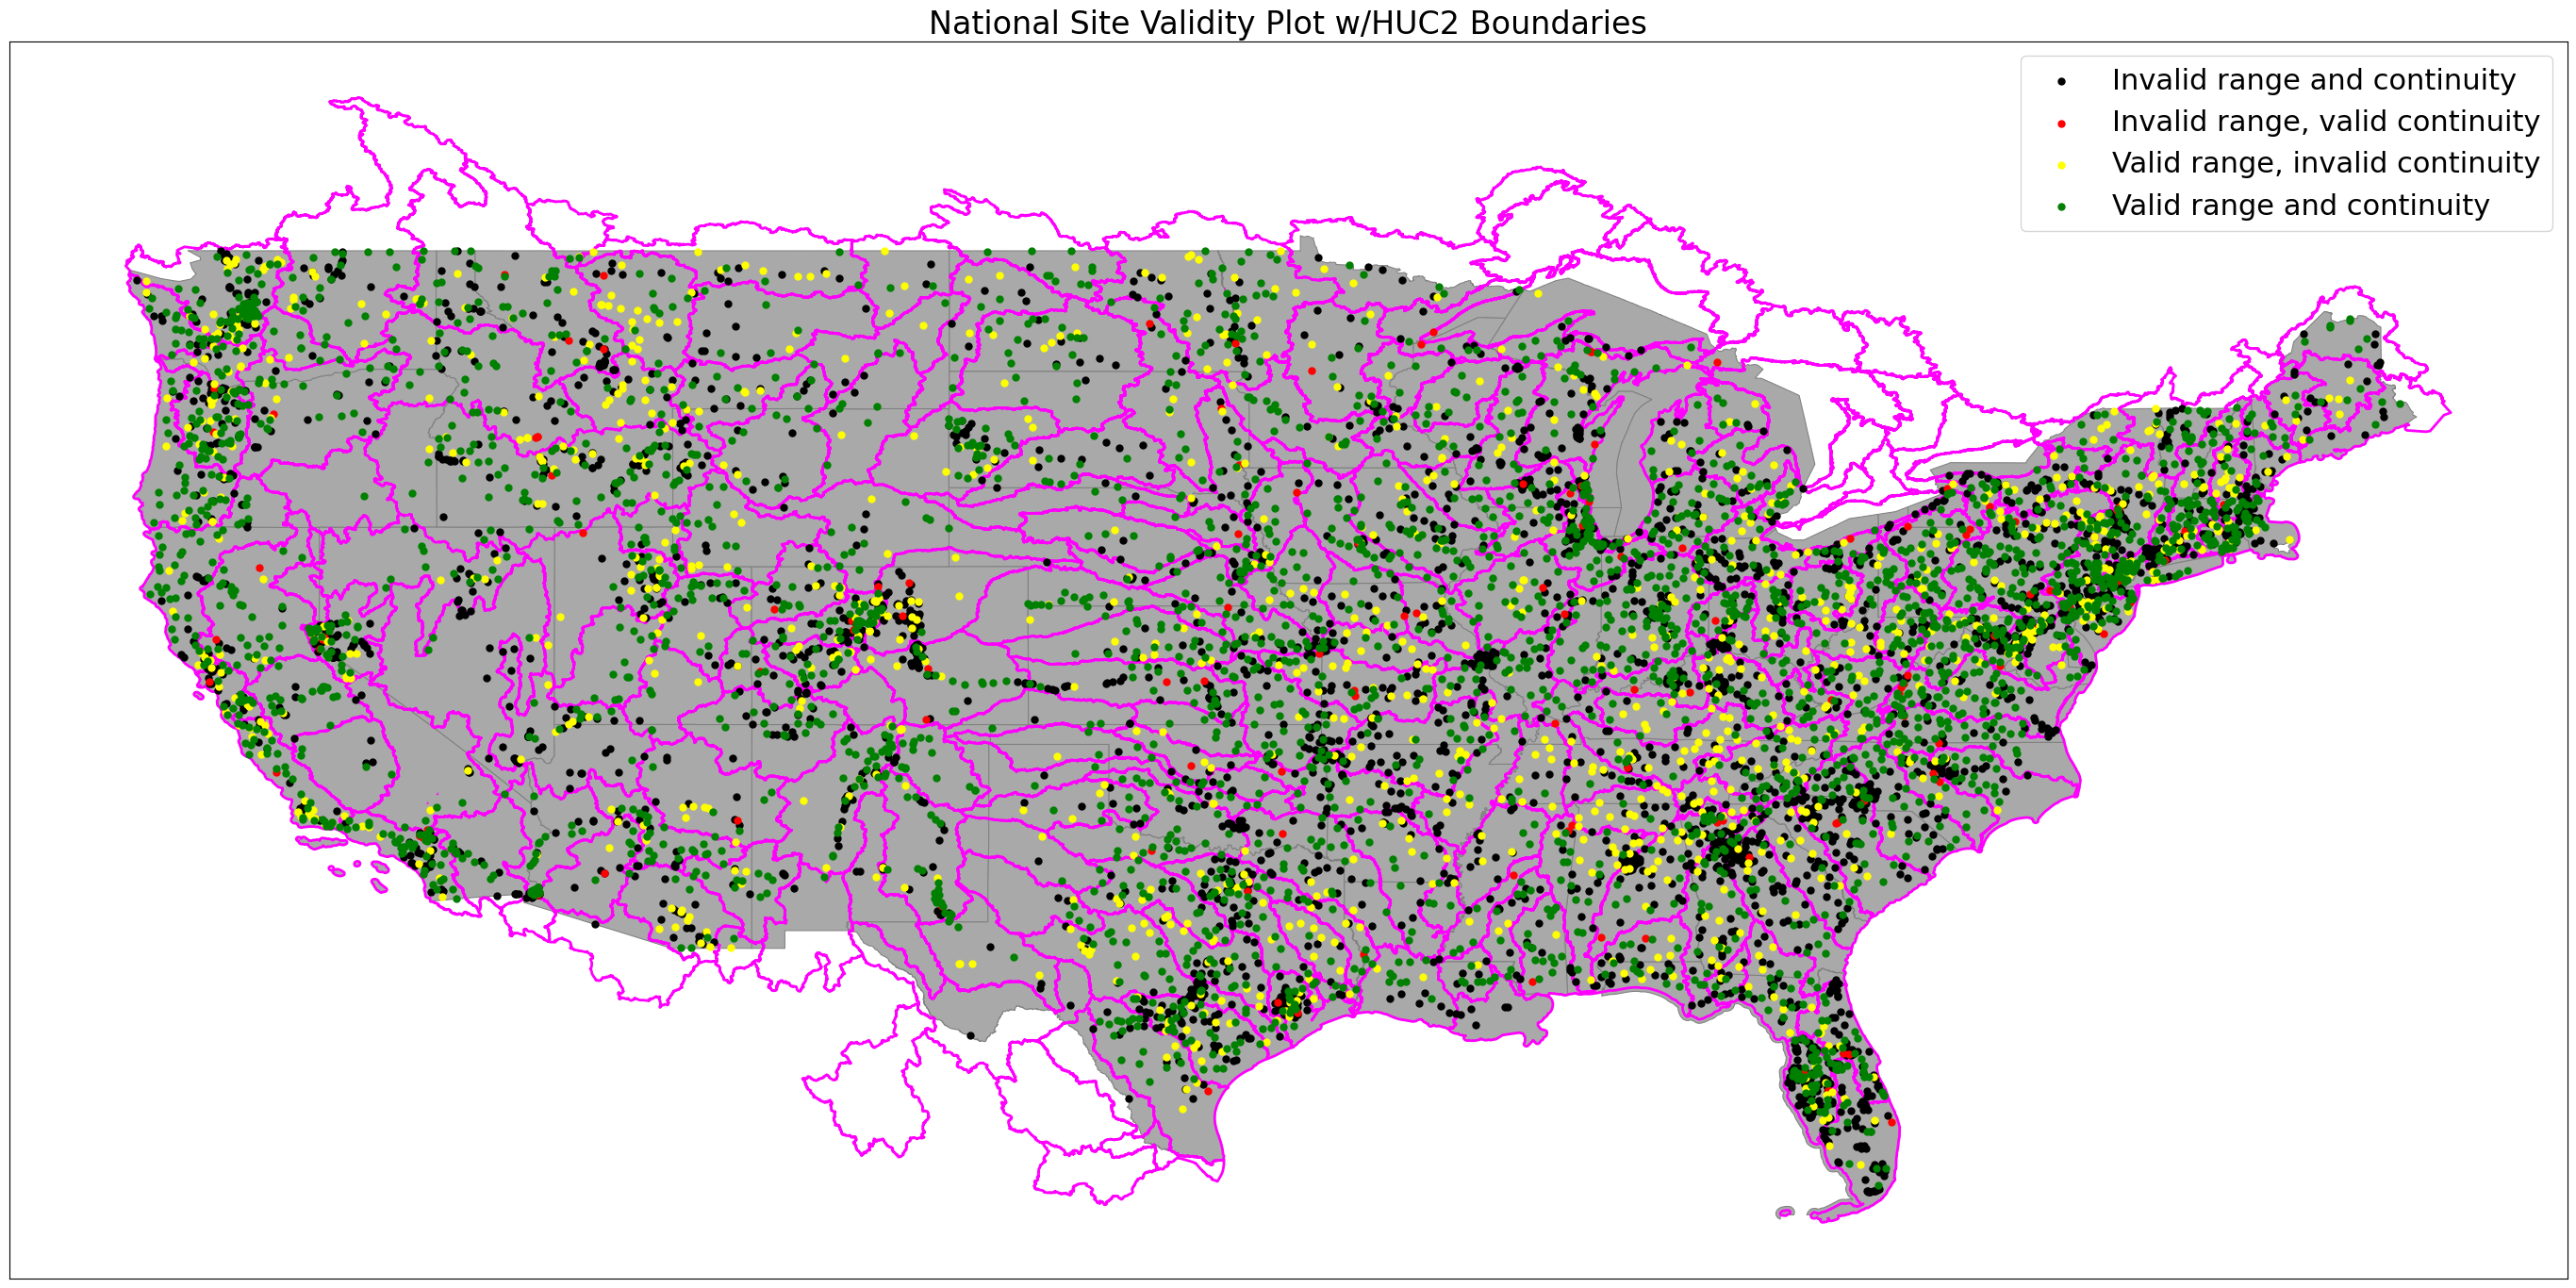

Total Sites with 00060_Mean Data: 8070
Valid Range and Continuity: 3172 (39.31%)
Valid Range, Invalid Continuity: 1123 (13.92%)
Invalid Range, Valid Continuity: 143 (1.77%)
Invalid Range and Continuity: 3632 (45.01%)


In [143]:
fig, ax = plt.subplots(figsize=(35, 35))
plt.title(f"National Site Validity Plot w/HUC2 Boundaries", loc='center', fontsize=24)

fn.plot_lower_48(ax)

if show_rateb_aqs:
    fn.plot_rateb_aquifers(ax=ax, edgecolor='darkorange', facecolor='orange', alpha=0.5)
    
if show_huc2:
    fn.plot_huc2(ax=ax, codes=[], linewidth=2.0, edgecolor='fuchsia', facecolor='none', alpha=1.0)
    
if show_huc4:
    fn.plot_huc4(ax=ax, codes=[], linewidth=2.0, edgecolor='fuchsia', facecolor='none', alpha=1.0)

geo_df = fn.convert_geometry(df_validity)

colors = df_validity['data_range'].astype(str) + df_validity['data_cont'].astype(str)
gdf_green = geo_df[colors == 'TrueTrue']
gdf_yellow = geo_df[colors == 'TrueFalse']
gdf_red = geo_df[colors == 'FalseTrue']
gdf_black = geo_df[colors == 'FalseFalse']

gdf_black.plot(ax=ax, color='black', label='Invalid range and continuity', markersize=100, marker='.', alpha=1.0)
gdf_red.plot(ax=ax, color='red', label='Invalid range, valid continuity', markersize=100, marker='.', alpha=1.0)
gdf_yellow.plot(ax=ax, color='yellow', label='Valid range, invalid continuity', markersize=100, marker='.', alpha=1.0)
gdf_green.plot(ax=ax, color='green', label='Valid range and continuity', markersize=100, marker='.', alpha=1.0)

ax.set_xticks([])
ax.set_yticks([])
plt.legend(prop={'size': 22})
plt.show()

print(f'Total Sites with 00060_Mean Data: {len(df_validity)}')
print(f'Valid Range and Continuity: {len(gdf_green)} ({round(len(gdf_green)/len(df_validity)*100, 2)}%)')
print(f'Valid Range, Invalid Continuity: {len(gdf_yellow)} ({round(len(gdf_yellow)/len(df_validity)*100, 2)}%)')
print(f'Invalid Range, Valid Continuity: {len(gdf_red)} ({round(len(gdf_red)/len(df_validity)*100, 2)}%)')
print(f'Invalid Range and Continuity: {len(gdf_black)} ({round(len(gdf_black)/len(df_validity)*100, 2)}%)')

## Monthly HMF Frequency per Aquifer Plot
This plot shows the average frequency in which sites experienced HMF, broken down by month, across an aquifer region. The `mfreq_` datasheets are generated by commented out code in `monthly_hmf()` automatically when aquifer analysis is run. To generate an `mfreq_` dataset, uncomment the code, run aquifer analysis, and then move/rename the resulting dataset to `'Sample_Sheets/mfreq_{aquifer_name}_{range}_{quantile}.csv'`

In [81]:
aquifer = cl.arizona_alluvial_aquifer
range = 30
quantile = 90

hist_data_set = f'mfreq_{aquifer.name}_{range}_{quantile}.csv'
hist_data_path = f'Sample_Sheets/{hist_data_set}'

num_sites = len(pd.read_excel(f'Prelim_Data/{aquifer.name}/{aquifer.name}_{range}_{quantile}.xlsx'))

df_freq = pd.read_csv(hist_data_path)
df_freq = df_freq.sort_values('month')
df_freq = df_freq.drop(columns='Unnamed: 0')
df_freq = df_freq.reset_index(drop=True)
df_freq = df_freq.fillna(0)
df_freq['count'] = df_freq['count'] / num_sites
df_freq['00060_Mean'] = df_freq['00060_Mean'] / num_sites

C:\Users\alekh\AppData\Local\Temp\ipykernel_9116\3884315333.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable, ax=None)


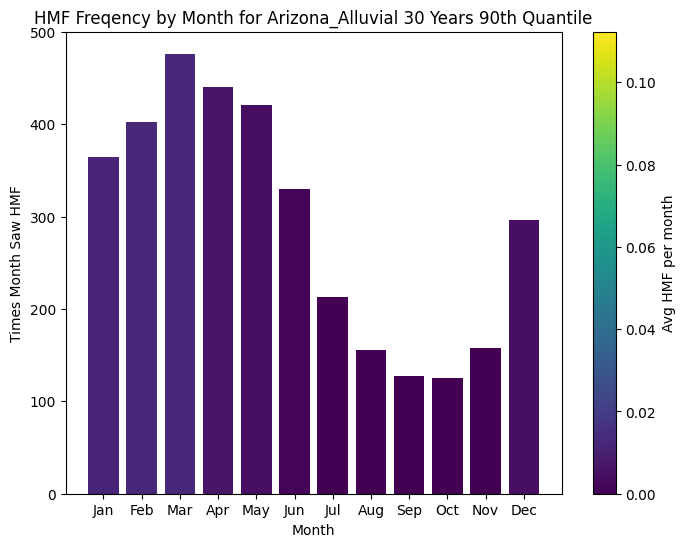

In [82]:
plt.figure(figsize=(8, 6))
plt.xticks(df_freq['month'], [calendar.month_name[int(m)][:3] for m in df_freq['month']], rotation=0)

vmin = df_freq['00060_Mean'].min()
vmax = df_freq['00060_Mean'].max()
norm = mcolors.Normalize(vmin, vmax)
cmap = 'viridis'
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(df_freq['00060_Mean'])

bars = plt.bar(df_freq['month'], df_freq['count'], color=plt.cm.viridis(df_freq['00060_Mean']))
cbar = plt.colorbar(mappable, ax=None)
cbar.set_label('Avg HMF per month')
plt.title(f'HMF Freqency by Month for {aquifer.name} {range} Years {quantile}th Quantile')
plt.xlabel('Month')
plt.ylabel('Times Month Saw HMF')
plt.show()